<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/MultilayeredStructuresSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This demo solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) multilayered structures, (2) membrane permeability, (3) pure homogeneous Neumann 

# Copyright (C) 2017 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-09

# This demo is maintained by Van-Dang Nguyen
# Please report problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [37]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3



dolfin version: 2018.1.0


# Download the mesh and submesh

Extracting cell markers from: multi_layer_disk.msh ...
Extracted successfully on: 908 elements
Wrote to: volmk_multi_layer_disk.xml


'\n!rm -rf *\n!wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus.xml.zip\n!wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus_compt1.xml.zip\n!unzip -q multi_layer_torus.xml.zip\n!unzip -q multi_layer_torus_compt1.xml.zip\n!rm -rf *.zip *MACOSX\n\n# Load multilayered torus mesh and submesh\nmesh = Mesh("multi_layer_torus.xml");  \ncmpt_mesh = Mesh(\'multi_layer_torus_compt1.xml\')\n\n'

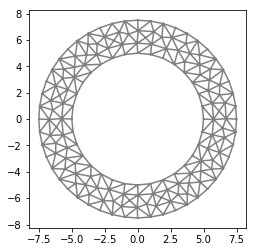

In [38]:
!rm -rf *
!wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/extract_cell_marker.py
!wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/multi_layer_disk.geo
!sed -i 's/5, 7.5, 10, 13/5, 7.5, 10/g' multi_layer_disk.geo
!apt-get install gmsh


!gmsh -2 multi_layer_disk.geo -o multi_layer_disk.msh
!dolfin-convert multi_layer_disk.msh multi_layer_disk.xml

mesh = Mesh("multi_layer_disk.xml");  

clear_output()

!python3 extract_cell_marker.py multi_layer_disk.msh

cellmarker = MeshFunction("size_t", mesh, mesh.topology().dim())

File("volmk_multi_layer_disk.xml")>>cellmarker

cmpt_mesh = SubMesh(mesh, cellmarker, 1)

plot(cmpt_mesh)
'''
!rm -rf *
!wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus.xml.zip
!wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus_compt1.xml.zip
!unzip -q multi_layer_torus.xml.zip
!unzip -q multi_layer_torus_compt1.xml.zip
!rm -rf *.zip *MACOSX

# Load multilayered torus mesh and submesh
mesh = Mesh("multi_layer_torus.xml");  
cmpt_mesh = Mesh('multi_layer_torus_compt1.xml')

'''


# Setup phase-function for multilyered structures

In [0]:
gdim = mesh.geometry().dim()

V_DG = FunctionSpace(mesh, 'DG', 0)
dofmap_DG = V_DG.dofmap()
phase = Function(V_DG)
cellmarker = MeshFunction("size_t", mesh, mesh.topology().dim())

for cell in cells(mesh):
    p = cell.midpoint();
    is_in_cmpt = cmpt_mesh.bounding_box_tree().compute_first_entity_collision(p)<4294967295
    phase.vector()[dofmap_DG.cell_dofs(cell.index())] = is_in_cmpt;
    cellmarker[cell.index()] = is_in_cmpt;


# plot(phase, cmap="coolwarm");
mesh0 = SubMesh(mesh, cellmarker, 0)
mesh1 = SubMesh(mesh, cellmarker, 1)
File("Phase.pvd")<<phase
File("mesh0.xml")<<mesh0
File("mesh1.xml")<<mesh1


#Pre-defined functions

In [0]:
def MyFunctionSpaces(mesh, porder):
  Ve = FiniteElement("CG", mesh.ufl_cell(), porder)
  TH = MixedElement([Ve,Ve,Ve,Ve])
  V = FunctionSpace(mesh,Ve);
  W = FunctionSpace(mesh, TH)
  return Ve, V, W

def GdotX(g0, g1, g2, mesh):
  gdim = mesh.geometry().dim()
  if (gdim==2):
    GX=Expression("x[0]*g0+x[1]*g1", g0=g0, g1=g1, domain=mesh, degree=3);
  if (gdim==3):
    GX=Expression("x[0]*g0+x[1]*g1+x[2]*g2", g0=g0, g1=g1, g2=g2, domain=mesh, degree=3);
  return GX;

def FuncF(ft, gnorm, GX, ur, ui, vr, vi, K):
    Fr = ft*gnorm*GX*ui*vr - inner(K*grad(ur), grad(vr))
    Fi = - ft*gnorm*GX*ur*vi - inner(K*grad(ui), grad(vi))
    return Fr + Fi
  
def icondition(kappa, u0rm, u1rm, v0r, v1r, u0im, u1im, v0i, v1i):
    F_bcr = kappa*(u0rm-u1rm)*(v0r-v1r)
    F_bci = kappa*(u0im-u1im)*(v0i-v1i)
    return F_bcr + F_bci

def SubMeshSave(ur, ui, file_ur, file_ui, mesh, n, stepcounter, dolfin_version):
  if dolfin_version=='1.6.0':
    V = FunctionSpace(mesh, "CG", porder)
  else:
    # For FEniCS 2016, 2017
    Ve = FiniteElement("CG", mesh.ufl_cell(), porder)
    V = FunctionSpace(mesh, Ve)
  if stepcounter % n == 0:
    ur_p = project(ur, V);
    ui_p = project(ui, V);
    ur_p.rename("Real", "label");
    ui_p.rename("Imag", "label");
    file_ur << ur_p;
    file_ui << ui_p;

def ieval(u,omega, phase):
  if omega==1:
    return u('+')*phase('+') + u('-')*phase('-');
  if omega==0:
    return u('+')*(1.-phase('+')) + u('-')*(1.-phase('-'))                      

def time_profile(t, delta, Delta, stype):
  ft1, ft2 = 0, 0;
  if stype=='PGSE':
    ft1 = 1.0*(t>=0 and t<delta) 
    ft2 = -1.0*(t>=Delta and t<=Delta+delta);
  if stype=='cos_OGSE':
    ft1 =  cos(2.0*nperiod*pi*t/delta)*(t>=0 and t<delta);
    ft2 = -cos(2.0*nperiod*pi*(t-2.*delta)/delta)*(t>=Delta and t<=Delta+delta);
  return ft1 + ft2; 

def ThetaMethod_L(ft, gnorm, GX, u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, u0r_0, u0i_0, u1r_0, u1i_0,k, kappa, K, theta, phase):
    L0 = (u0r_0/k*v0r + u0i_0/k*v0i+(1-theta)*FuncF(ft, gnorm, GX, u0r_0, u0i_0, v0r, v0i, K))*(1-phase)*dx
    L1 = (u1r_0/k*v1r +u1i_0/k*v1i+(1-theta)*FuncF(ft, gnorm, GX, u1r_0, u1i_0, v1r, v1i, K))*phase*dx
    L_bc = avg((1-theta)*icondition(kappa, u0r_0, u1r_0, v0r, v1r, u0i_0, u1i_0, v0i, v1i))*abs(jump(phase))*dS;
    return L0+L1-L_bc


def ThetaMethod_a(ft, gnorm, GX, u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, u0r_0, u0i_0, u1r_0, u1i_0,k,kappa, K, theta, phase):
    a0 = (u0r/k*v0r   + u0i/k*v0i  -theta*FuncF(ft, gnorm, GX, u0r  , u0i  , v0r, v0i, K))*(1-phase)*dx
    a1 = (u1r/k*v1r   + u1i/k*v1i  -theta*FuncF(ft, gnorm, GX, u1r  , u1i  , v1r, v1i, K))*phase*dx
    a_bc = avg(  (theta*icondition(kappa, u0r  , u1r  , v0r, v1r, u0i  , u1i  , v0i, v1i)))*abs(jump(phase))*dS;
    return a0+a1+a_bc


def NoTimeMatrices(u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, K, GX, kappa, theta, phase):
    m0 = (u0r*v0r   + u0i*v0i)*(1-phase)*dx
    m1 = (u1r*v1r   + u1i*v1i)*phase*dx
    M = assemble(m0+m1);
        
    j0 = -GX*(u0i*v0r   - u0r*v0i)*(1-phase)*dx
    j1 = -GX*(u1i*v1r   - u1r*v1i)*phase*dx
    J = assemble(j0+j1);    
    s0 = ( inner(K*grad(u0r), grad(v0r)) + inner(K*grad(u0i), grad(v0i)) )*(1-phase)*dx
    s1 = ( inner(K*grad(u1r), grad(v1r)) + inner(K*grad(u1i), grad(v1i)) )*phase*dx
    S = assemble(s0+s1)

    im = avg(  icondition(kappa, u0r  , u1r  , v0r, v1r, u0i  , u1i  , v0i, v1i) )*abs(jump(phase))*dS;
    I = assemble(im)
    
    M.ident_zeros();
    
    return M, J, S, I

def ThetaMethod_A(ft, gnorm, theta, k, M, J, S, I):
    return 1./k*M + ft*gnorm*theta*J + theta*S + theta*I
  
def b2g(bvalue, delta, Delta, nperiod, stype):
  gnorm = 0;
  if (stype == 'PGSE'):
      gnorm = sqrt(bvalue)/sqrt(delta*delta*(Delta-delta/3.0));
  if (stype == 'cos_OGSE'):
      gnorm = sqrt(bvalue/(1./8.*delta*delta*delta*(3.-cos(4.*nperiod*pi/delta*Delta))/(nperiod*nperiod)/(pi*pi)));
  return gnorm;

def g2b(gnorm, delta, Delta, nperiod, stype):
  bvalue = 0;
  if (stype == 'PGSE'):
      bvalue = gnorm*gnorm*delta*delta*(Delta-delta/3.0);
  if (stype == 'cos_OGSE'):
      bvalue=gnorm*gnorm*1./8.*delta*delta*delta*(3.-cos(4.*nperiod*pi/delta*Delta))/(nperiod*nperiod)/(pi*pi);
  return bvalue;  



# Pre-defined parameters

In [0]:
bvalue = 4000;             # bvalue
delta, Delta = 40000, 40000 # PGSE sequence
g0, g1, g2 = 1, 0, 0;       # gradient direction
theta = 0.5;                # theta=0.5: midpoint method
K = 3e-3;                   # Diffusion coefficient
kappa = 5e-5                # Permeability
nskip = 5;                  # Output frequency (for visualization only)
porder = 1;                 # order of basis functions of FEM
Nsteps = 200;               # number of time intervals
nperiod = 0;
stype='PGSE'
t, T = 0, Delta+delta;
k = 1000; # Time-step size


# Solve the Bloch-Torrey equation

t: 0.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 0.00%
t: 5000.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 6.17%
t: 10000.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 12.35%
t: 15000.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 18.52%
t: 20000.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 24.69%
t: 25000.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 30.86%
t: 30000.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 37.04%
t: 35000.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 43.21%
t: 40000.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 49.38%
t: 45000.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 55.56%
t: 50000.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 61.73%
t: 55000.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 67.90%
t: 60000.000000  T: 80000.0 dt:1000.0 gnorm: 9.682458e-06 Completed 74.07%
t: 65000.000000  T: 80000.0 dt:1

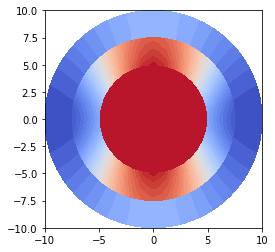

In [42]:
if (Delta-delta/3.0<=0):
    print('Check time sequence!');
    exit(0);
    
gnorm = b2g(bvalue, delta, Delta, nperiod, stype)

#################################################################################
# FUNCTION SPACES
Ve, V, W = MyFunctionSpaces(mesh, porder)
v = TestFunction(W)
v0r, v0i, v1r, v1i = v[0], v[1], v[2], v[3]

w = TrialFunction(W);
u0r, u0i, u1r, u1i = w[0], w[1], w[2], w[3]
#################################################################################

#################################################################################
# Initial conditions
one = Function(V);
one.vector()[:] = 1.0;
u_0 = Function(W);
assign(u_0.sub(0), one)
assign(u_0.sub(2), one)
u0r_0, u0i_0, u1r_0, u1i_0 = u_0[0], u_0[1], u_0[2], u_0[3]
#################################################################################

GX=GdotX(g0, g1, g2, mesh)
#################################
## output files 
file_u0r = File("results/u0r.pvd")
file_u0i = File("results/u0i.pvd")
file_u1r = File("results/u1r.pvd")
file_u1i = File("results/u1i.pvd")
#################################

stepcounter = 0;


hmin = mesh.hmin();

M, J, S, I = NoTimeMatrices(u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, K, GX, kappa, theta, phase);


ft_prev = time_profile(t, delta, Delta, stype);

start_time = time.time()

while t < T + k: # Time-stepping loop
    if stepcounter % nskip == 0:
        print('t: %f '%t, 'T: %.1f'%T, 'dt:%.1f'%k,'gnorm: %e'%gnorm,'Completed %.2f%%'%(float(t)/float(T+k)*100.0));

    ft = time_profile(t, delta, Delta, stype);

    L = ThetaMethod_L(ft_prev, gnorm, GX, u0r, u0i, v0r, v0i, u1r, u1i, v1r, v1i, u0r_0, u0i_0, u1r_0, u1i_0,k, kappa, K, theta, phase);
    A = ThetaMethod_A(ft, gnorm, theta, k, M, J, S, I);
    b = assemble(L);

    u = Function(W)
    solve(A,u.vector(),b, "gmres", "ilu");
    
    u0r_0, u0i_0, u1r_0, u1i_0 = split(u)
    
    SubMeshSave(u0r_0, u0i_0, file_u0r, file_u0i, mesh0, nskip, stepcounter, dolfin_version);
    SubMeshSave(u1r_0, u1i_0, file_u1r, file_u1i, mesh1, nskip, stepcounter, dolfin_version);
    
    ft_prev = ft;
    
    t += k;
    stepcounter += 1;
    
elapsed_time = time.time() - start_time
print("Elapsed time: %f seconds"%elapsed_time)

signal = assemble((phase*u1r_0+(1-phase)*u0r_0)*dx)/assemble(one*dx);
print('b:',bvalue, 'Signal: %.3e'%signal,'kappa: %.3e'%kappa,', dt:',k,', hmin:',hmin)


V0 = FunctionSpace(mesh0,Ve);
V1 = FunctionSpace(mesh1,Ve);
u0r_0p = project(u0r_0,V0)
u1r_0p = project(u1r_0,V1)
plot(u0r_0p, cmap="coolwarm")
plot(u1r_0p, cmap="coolwarm")

# Reference solutions

In [0]:
# The results were generated by the Matrix Formalism method propsed in
# D.S. Grebenkov, Pulsed-gradient spin-echo monitoring of restricted 
# diffusion in multilayered structures, J. Magn. Reson., 205 (2) (2010)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # R=[5,7.5,10], kappa=5e-5m/s delta=Delta=40000
#  bvalue  # signal attenuation
# # # # # # # # # # # # # # #
# # # # # # # # # # # # # # #


